In [1]:
import pandas as pd
import numpy as np
import warnings

# to make a clean output
np.seterr(over='ignore', divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore", category=RuntimeWarning)

df = pd.read_csv("cleaned_data.csv")
df.shape

(5297, 148)

In [2]:
target = "hospital_expire_flag"

# Columns we don't want to use as features
id_cols = [
    "subject_id", "hadm_id", "stay_id",
    "Group_Name", "Term", "DOID", "ICD10Code"
]

time_cols = [
    "dod", "admittime", "dischtime",
    "icu_intime", "icu_outtime",
    "admittime_1", "dischtime_1", "deathtime", "dod_1"
]

leak_cols = ["los_hospital", "los_icu"]

drop_cols = id_cols + time_cols + leak_cols + [target]

# define the feature matrix and respond vector
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df[target]
# convert the subject id to patient index
codes, uniques = pd.factorize(df['subject_id'])

# make sure all the columns of the feature matrix is numeric for regression
bool_cols = X.select_dtypes("bool").columns
X[bool_cols] = X[bool_cols].astype(int)
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
feature_names = X_encoded.columns.to_list()
X = X_encoded.to_numpy(dtype=float)
y = y.to_numpy(dtype=float)
ids = codes.astype(int) 

In [3]:
from scipy.special import expit
def loglik_hier(beta, z, b, X, y, ids):
    """
    logistic log-likelihood
    """
    beta_eff = beta * z
    eta = X @ beta_eff + b[ids]
    return np.sum(y * eta - np.log1p(np.exp(eta)))


def update_sigma2_b(b_curr, a0=0.001, b0=0.001, rng=None):
    """
    Gamma conjugate posterior
    """
    if rng is None:
        rng = np.random.default_rng()
    n_id = b_curr.shape[0]
    a_post = a0 + n_id / 2.0
    b_post = b0 + 0.5 * np.sum(b_curr**2)
    gamma_sample = rng.gamma(shape=a_post, scale=1.0 / b_post)
    sigma2_b = 1.0 / gamma_sample
    return sigma2_b


def flip_z_hier(z_curr, beta_curr, b_curr, X, y, ids, rng=None):
    """
    A single update for z
    """
    if rng is None:
        rng = np.random.default_rng()

    p = len(z_curr)
    z = z_curr.copy()

    for j in rng.permutation(p):
        z0 = z.copy()
        z1 = z.copy()
        # propose the flip
        z0[j] = 0.0
        z1[j] = 1.0
        # compute the corresponding likelihood
        ll0 = loglik_hier(beta_curr, z0, b_curr, X, y, ids)
        ll1 = loglik_hier(beta_curr, z1, b_curr, X, y, ids)
        # compute the full conditional probability
        log_odds = ll1 - ll0
        p1 = expit(log_odds)

        z[j] = rng.binomial(1, p1)

    return z


In [4]:
from polyagamma import random_polyagamma
from numpy.random import default_rng

def pg_update_beta_b(beta_curr, b_curr, z_curr, X, Z_mat, y,
                     sigma0=100.0, sigma2_b=1.0, rng=None):
    """
    A single step for Polya Gamma Data Augmentation step
    """

    if rng is None:
        rng = default_rng()

    n, p = X.shape
    n_id = Z_mat.shape[1]

    # stack the covariate matrix and the id matrix
    X_z = X * z_curr
    X_tilde = np.hstack([X_z, Z_mat])

    # combine the two priors to form the precision matrix
    prec_beta = np.full(p, 1.0 / sigma0**2)
    prec_b = np.full(n_id, 1.0 / sigma2_b)
    Sigma0_inv = np.diag(np.concatenate([prec_beta, prec_b]))

    # sample latent variable
    beta_eff = beta_curr * z_curr
    eta = X @ beta_eff + Z_mat @ b_curr
    eta = np.clip(eta, -30.0, 30.0)
    omega = random_polyagamma(1.0, np.asarray(eta, dtype=float))

    # other parameters for sampling beta and b
    kappa = y - 0.5
    WX = X_tilde * omega[:, None]
    XtWX = X_tilde.T @ WX

    # precision matrix
    Q = XtWX + Sigma0_inv
    I_q = np.eye(Q.shape[0])

    # try Cholesky with increasing ridge if needed
    eps = 1e-6
    for _ in range(6):
        try:
            Q_reg = Q + eps * I_q
            R = np.linalg.cholesky(Q_reg) 
            break
        except np.linalg.LinAlgError:
            eps *= 10.0

    # mean: solve Q_reg * m = X_tilde^T kappa
    rhs = X_tilde.T @ kappa
    m_om = np.linalg.solve(Q_reg, rhs)

    # sample from MNV via Cholesky
    z = rng.normal(size=Q_reg.shape[0])
    u = np.linalg.solve(R.T, z)
    theta_new = m_om + u

    beta_new = theta_new[:p]
    b_new = theta_new[p:]

    return beta_new, b_new


In [5]:
def run_mcmc_pg_hier(X, y, ids,
                     sigma0=100.0,
                     n_iter=5000,
                     burn_in=1000,
                     a0=0.001, b0=0.001,
                     seed=111):
    """
    X: (n, p) numpy array
    y: (n,) numpy array, 0/1
    ids: (n,) numpy array of subject indices, should be converted 0,...,n_id-1
    """
    rng = default_rng(seed)

    n, p = X.shape
    n_id = len(np.unique(ids))

    # construct the id dummy variable
    Z_mat = np.zeros((n, n_id), dtype=float)
    Z_mat[np.arange(n), ids] = 1.0

    # initialize parameters
    beta_curr = np.zeros(p)
    z_curr = np.ones(p)
    sigma2_b = 1.0
    b_curr = rng.normal(loc=0.0, scale=np.sqrt(sigma2_b), size=n_id)

    B_save = np.zeros((n_iter, p)) # beta parameters
    Z_save = np.zeros((n_iter, p)) # feature selection indicator
    sigma2_b_save = np.zeros(n_iter)

    for it in range(n_iter):
        # update coefs by PG method
        beta_curr, b_curr = pg_update_beta_b(
            beta_curr, b_curr, z_curr,
            X, Z_mat, y,
            sigma0=sigma0,
            sigma2_b=sigma2_b,
            rng=rng
        )

        # update sigma_b^2
        sigma2_b = update_sigma2_b(b_curr, a0=a0, b0=b0, rng=rng)

        # update z
        z_curr = flip_z_hier(z_curr, beta_curr, b_curr, X, y, ids, rng=rng)

        # save
        B_save[it, :] = beta_curr
        Z_save[it, :] = z_curr
        sigma2_b_save[it] = sigma2_b

        if (it + 1) % 1000 == 0:
            print(f"iter = {it+1} / {n_iter}")

    # discard the burnin period
    keep = np.arange(burn_in, n_iter)

    return {
        "B": B_save[keep, :],
        "Z": Z_save[keep, :],
        "sigma2_b": sigma2_b_save[keep]
    }


In [6]:
from sklearn.preprocessing import StandardScaler

subjects = df["subject_id"].unique()
rng = np.random.default_rng(638)
# assign the subject ids to random order and pick 80%
rng.shuffle(subjects)
n_train_subj = int(0.8 * len(subjects))
# split the train and test ids
train_subj = subjects[:n_train_subj]
test_subj = subjects[n_train_subj:]

# extract the corresponding patients' records
train_mask = df["subject_id"].isin(train_subj).values
test_mask = ~train_mask
# split the train and test data
X_train = X[train_mask, :]
y_train = y[train_mask]
X_test = X[test_mask, :]
y_test = y[test_mask]

# extract the train and test ids in order
codes_train, uniq_train = pd.factorize(df.loc[train_mask, "subject_id"])
codes_test, uniq_test = pd.factorize(df.loc[test_mask, "subject_id"])
# turn them to id index
ids_train = codes_train.astype(int)
ids_test  = codes_test.astype(int)

# standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [7]:
# run model with uninformative prior
sample_dict = run_mcmc_pg_hier(
    X_train_scaled, y_train, ids_train,
    sigma0=10,
    n_iter=8000,
    burn_in=2000,
    a0=0.001, b0=0.001,
    seed=111
)

B_samples = sample_dict["B"]
Z_samples = sample_dict["Z"]
sigma2_samples = sample_dict["sigma2_b"]

iter = 1000 / 8000
iter = 2000 / 8000
iter = 3000 / 8000
iter = 4000 / 8000
iter = 5000 / 8000
iter = 6000 / 8000
iter = 7000 / 8000
iter = 8000 / 8000


median ESS of beta samples: 5802.563483260111


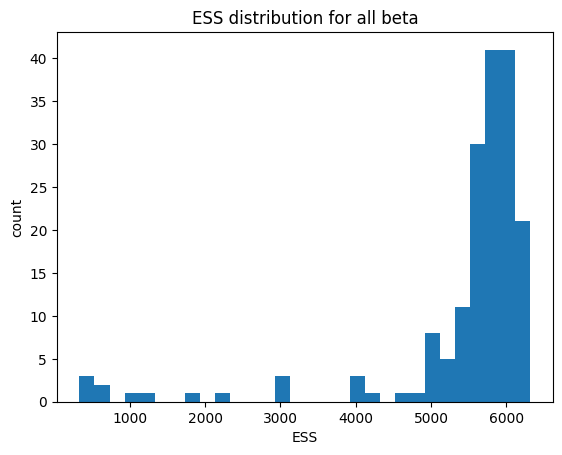

In [8]:
# compute the effective sample size of beta
import arviz as az
import xarray as xr
import matplotlib.pyplot as plt

S, p = B_samples.shape

# form a one-chain posterior samples to perform ess function
beta_da = xr.DataArray(
    B_samples[np.newaxis, :, :], 
    dims=("chain", "draw", "beta")
)

# calculate ess and extract
ess_beta_da = az.ess(beta_da)
ess_beta = ess_beta_da["x"].values

print("median ESS of beta samples:", np.median(ess_beta))

plt.hist(ess_beta, bins=30)
plt.xlabel("ESS")
plt.ylabel("count")
plt.title("ESS distribution for all beta")
plt.show()


We could see from the histogram that for a very large proportion of features, the effective sample size are close to the total number of post-burnin iterations, suggesting well mixing and independent posterior samples.

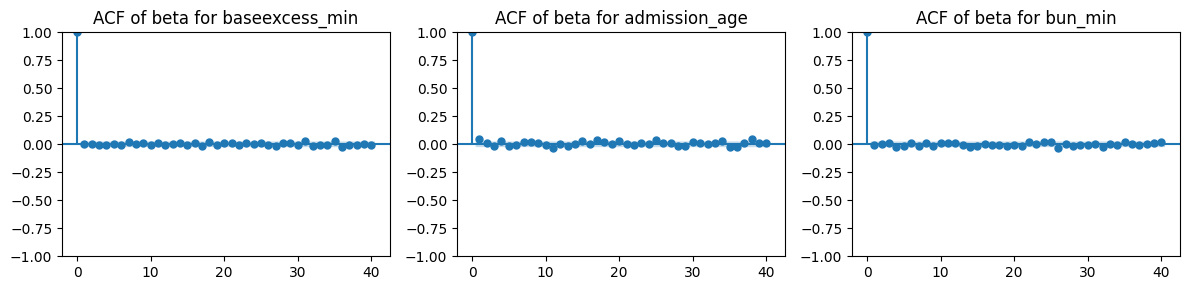

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# extract the overlapped top features in ML baseline to see the acf
ml_top = [
    "baseexcess_min",
    "admission_age",
    "bun_min",
]

idx_list = []

for n in ml_top:
    idx_list.append(feature_names.index(n))

# plot acf
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for k, (name, idx) in enumerate(zip(ml_top, idx_list)):
    beta_chain = B_samples[:, idx]

    # acfs for beta
    plot_acf(beta_chain, lags=40, ax=axes[k])
    axes[k].set_title(f"ACF of beta for {name}")

plt.tight_layout()
plt.show()

We could see that the autocorrelation is also very low, suggesting the well mixing for the selected features.

In [13]:
# compute the posterior inclusion probability
pip_all = Z_samples.mean(axis=0)

# extract the important features suggested by the model
feature_idx = np.where(pip_all > 0.5)[0]
feature_names_np = np.array(feature_names)

pip_table = pd.DataFrame({
    "index": feature_idx,
    "feature": feature_names_np[feature_idx],
    "PIP": pip_all[feature_idx]
})

pip_table = pip_table.sort_values("PIP", ascending=False).reset_index(drop=True)

pip_table.style.hide(axis="index")

index,feature,PIP
2,first_hosp_stay,1.000000
119,urineoutput,1.000000
70,heart_rate_max,0.987500
140,race_HISPANIC/LATINO - HONDURAN,0.856667
111,temperature_min_1,0.814000
112,temperature_max_1,0.812667
86,temperature_mean,0.769000
16,albumin_max,0.680667
163,admission_location_INTERNAL TRANSFER TO OR FROM PSYCH,0.588167
65,ck_mb_min,0.552167


This enjoys a large overlap with our XGBoost result.

In [11]:
# posterior predictive check
from scipy.special import expit
from sklearn.metrics import roc_auc_score, brier_score_loss

S, p = B_samples.shape
n_test = X_test_scaled.shape[0]
n_subj_test = len(uniq_test)

# to store the prediction for test
p_test_s = np.zeros((S, n_test))
rng = np.random.default_rng(638)

# predict by each sample
for s in range(S):
    beta_s = B_samples[s, :]
    z_s = Z_samples[s, :]
    sigma2_s = sigma2_samples[s]

    beta_eff_s = beta_s * z_s

    # assign a subject-specific randomness for each subject
    b_new_subj = rng.normal(loc=0.0, scale=np.sqrt(sigma2_s), size=n_subj_test)
    b_new_i = b_new_subj[ids_test]
    # predict the bernoulli probability
    eta_s = X_test_scaled @ beta_eff_s + b_new_i
    p_test_s[s, :] = expit(eta_s)

# mean among the predictions
p_test_hat = p_test_s.mean(axis=0)

# compute the auc for the prediction
auc_pg   = roc_auc_score(y_test, p_test_hat)
print("AUC by Polya Gamma method for hierarchical models:", auc_pg)


AUC by Polya Gamma method for hierarchical models: 0.711002525304371
